In [255]:
from bs4 import BeautifulSoup
from requests import get
import numpy as np
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import itertools
import json
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Standard plotly imports
import chart_studio.plotly as py
# Using plotly + cufflinks in offline mode
import cufflinks
import plotly.express as px
cufflinks.go_offline(connected=True)
import re
import time

In [256]:
def GetHtmlSoup(url, headers=()):
    try:
        response = get(url, headers=headers)
    except Exception as e:
        raise Exception(e)
        
    html_soup = BeautifulSoup(response.text, 'html.parser')
    
    return html_soup

In [257]:
def GetRetailContainer(url, name, attrs, **kwargs):
    html_soup = GetHtmlSoup(url)
    
    retail_container = html_soup.find_all(name, attrs, **kwargs)
    
    return retail_container

In [258]:
url = 'https://www.spacelist.ca/listings/b/dpz3q4u51j/dpxxegdyr8/retail-other/for-lease'
html_soup = GetHtmlSoup(url)

In [259]:
map_container = html_soup.find('div', {'id': 'cluster-map'})['data-data']
map_dict_list = json.loads(map_container)['features']
coord_dict = {f['properties']['id']: Point(f['geometry']['coordinates']) for f in map_dict_list}

In [260]:
n_pages = 85
n_ignored_address = 0
n_ignored_area = 0
n_ignored_rent = 0

business_dict = {'Id': [], 'Address': [], 'Area sf': [], 'Rent/mo': [], 'Type': [], 'geometry': []}
for page in range(1, n_pages + 1):
    url = 'https://www.spacelist.ca/listings/on/toronto/office-retail-industrial-medical-multifamily-other/for-lease/page/' + str(page)
    
    retail_container = GetRetailContainer(url, 'div', {'class': 'listing-result cell shrink'})
    
    if retail_container != []:
        page_location = 0
        for retail in retail_container:
            page_location += 1
            id_value = retail.find('a', {'class': 'add-to-shortlist'})['data-listing-id']
            
            rent_text = retail.find('div', {'class': 'rent_per_month'})
            
            if rent_text is not None:
                rent_text = rent_text.text                
            else:
                sub_url = 'https://www.spacelist.ca/listings/' + id_value + '/on/toronto/for-lease/retail'
                
                sub_html_soup = GetHtmlSoup(sub_url)
                retail_container = sub_html_soup.find_all('div', {'class': 'cell small-12 large-6'})
                rent_text = retail_container[0].find('span', {'class': 'bold-font'}).text

            try:
                rent_value = float(re.search(r'\$(.*?)\/', rent_text).group(1).replace(',', ''))
            except:

                n_ignored_rent += 1
                continue
                
            if 'sf/yr' in rent_text:
                rent_value = (rent_value * area_value) / 12
            
            try:
                address_value = retail.find(
                    'div',
                    {'class': 'cell auto small-font flat-line-height-taller right-cell-padding'})
                address_value = address_value.find('div', {'class': 'dark-font'}).get('title')
            except:
                n_ignored_address += 1
                continue
            
            try:
                area_text = retail.find('div', {'class': 'default-font dark-font flat-line-height'}).text

                if 'ft²' not in area_text or '-' in area_text:
                    n_ignored_area += 1
                    continue

                area_value = float(
                    re.findall(
                        '\d+(?:,\d+)?', 
                        area_text
                    )[0].replace(',', '')
                )
            except:
                n_ignored_area += 1
                continue

            type_value = retail.find('div', {'class': 'cell auto about'}).contents[1].text
            
            try:
                coord_value = coord_dict[int(id_value)]
            except:
                coord_value = np.nan
            
            business_dict['Id'].append(id_value)
            business_dict['Address'].append(address_value)
            business_dict['Area sf'].append(area_value)
            business_dict['Rent/mo'].append(rent_value)
            business_dict['Type'].append(type_value)
            business_dict['geometry'].append(coord_value)
    else:
        break
        
print('Number of spaces scraped:', len(business_dict['Id']), '\n')
print('Number of spaces ignored with an invalid address value:', n_ignored_address, '\n')
print('Number of spaces ignored with an invalid area value:', n_ignored_area, '\n')
print('Number of spaces ignored with an invalid rent value:', n_ignored_rent)

Number of spaces scraped: 642 

Number of spaces ignored with an invalid address value: 0 

Number of spaces ignored with an invalid area value: 30 

Number of spaces ignored with an invalid rent value: 786


In [261]:
retail_sl_df = pd.DataFrame(business_dict)
retail_sl_df.head()

,Id,Address,Area sf,Rent/mo,Type,geometry
0,191578,301 - 32 Britain St,165.0,2900.0,Office,NaN
1,278433,404 - 32 Britain St,165.0,3500.0,Office,NaN
2,184289,403 - 32 Britain St,260.0,6000.0,Office,NaN
3,319350,401 - 32 Britain St,350.0,6600.0,Office,NaN
4,284426,For Rent - 26 Duncan St,1200.0,8300.0,Office,NaN


In [262]:
n_unk_coord = retail_sl_df.loc[retail_sl_df['geometry'].isnull()].shape[0]
print('Number of unknown coordinates:', n_unk_coord)

Number of unknown coordinates: 566


In [263]:
retail_sl_df['Address'] = retail_sl_df.loc[:, ('Address')].apply(
    lambda s: s.replace(
        'For Rent - ', '').replace(
        'For Rent  - ', '').replace(
        'COWORKING DEDICATED - ', '').replace(
        ' COWORKING DEDICATED - ', '').replace(
        'COWORKING NOT RESERVED - ', '').replace(
        ' COWORKING NOT RESERVED - ', ''))
retail_sl_df['Main Address'] = retail_sl_df.loc[:, ('Address')].apply(
    lambda s: s.split('-')[-1].lstrip() if ('-' in s and 'HWY' not in s) else ('-'.join(s.split('-')[-2:]).lstrip() if 'HWY' in s else s))

In [264]:
na_address = np.unique(retail_sl_df.loc[retail_sl_df['geometry'].isnull()]['Main Address'])

coord_dict = {'Main Address': [], 'geometry': []}
geolocator = Nominatim(user_agent='web_scraper')
for addr in na_address:
    try:
        location = geolocator.geocode(addr + ' Toronto', timeout=10)
    except Exception as e:
        print(addr, e)
        continue
    try:
        addr_point = Point(location.longitude, location.latitude)
    except Exception as e:
        print(addr, e)
        continue
    coord_dict['geometry'].append(addr_point)
    coord_dict['Main Address'].append(addr)

In [265]:
geo_addr_gdf = gpd.GeoDataFrame(pd.DataFrame.from_dict(coord_dict))

retail_sl_df = retail_sl_df.merge(geo_addr_gdf, how='left', on='Main Address')
retail_sl_df.loc[retail_sl_df['geometry_x'].isnull(), 'geometry_x'] = retail_sl_df.loc[
    ~retail_sl_df['geometry_y'].isnull(), 'geometry_y']
retail_sl_df.drop('geometry_y', axis=1, inplace=True)
retail_sl_df.rename(columns={'geometry_x': 'geometry'}, inplace=True)

n_unk_coord = retail_sl_df.loc[retail_sl_df['geometry'].isnull()].shape[0]
print('Number of unknown coordinates:', n_unk_coord)

Number of unknown coordinates: 0


In [266]:
n_pages = 15
n_ignored = 0

business_dict_p2h = {'Id': [], 'Address': [], 'Area sf': [], 'Rent/mo': [], 'Type': [], 'geometry': []}
for page in range(1, n_pages + 1):
    url = 'https://www.point2homes.com/CA/Commercial-Properties-For-Lease.html?location=Toronto%2C+ON&PriceMin=0&PriceMax=1%2C000%2C000&search_mode=location&geopicker_output=853998%2C854002%2C854003%2C854008%2C854009%2C854010%2C854011%2C855493%2C855558%2C855562%2C855563&geopicker_type=nhood&geopicker_output_full=853998%7CEast+York%7COntario%2C854002%7CUptown+Toronto%7COntario%2C854003%7CYork%7COntario%2C854008%7CWest+End+Toronto%7COntario%2C854009%7CMidtown+Toronto%7COntario%2C854010%7CDowntown+Toronto%7COntario%2C854011%7CEast+End+Toronto%7COntario%2C855493%7CCaribou+Park%7CNorth+York%2C855558%7CGlen+Park%7CNorth+York%2C855562%7CLedbury+Park%7CNorth+York%2C855563%7CLawrence+Manor%7CNorth+York&page={}&SelectedView=listings&LocationGeoId=783094&viewport=-79.46408975087829%2C43.659463577335885%2C-79.35886132680602%2C43.76728718084169&zoom=13&location_changed=&ajax=1'.format(page)
    retail_container_p2h = GetRetailContainer(url, 'div', {'class': 'item-cnt clearfix'})

    if retail_container_p2h != []:
        for retail in retail_container_p2h:
            id_value = retail['id']
            
            # the lot size can be in acres, square feet, or it isn't listed
            # if it isn't listed then ignore the retail and continue the loop
            if retail.find('li', {'data-label': 'Lot Size'}) is None:
                if retail.find('li', {'data-label': 'Sqft'}) is None:
                    n_ignored += 1
                    continue
                else:
                    area_value = float(
                        re.findall(
                            '\d+(?:,\d+)?', 
                            retail.find('li', {'data-label': 'Sqft'}).text
                        )[0].replace(',', '')
                    )
            else:
                # convert acre to square feet

                area_value = float(
                    re.findall(
                        '\d+(?:.\d+)?',
                        retail.find('li', {'data-label': 'Lot Size'}).text
                    )[0]
                ) * 43560
            
            # if the rent is not given as a per month value, ignore it and continue the loop
            # the reason being that sometimes multiple spaces are listed with different rents in a
            # single listing, and the individual area and rent of each space is either not listed
            # or it's listed in paragraph form in a description field
            try:
                rent_value_month = float(
                    re.findall(
                        '\d+\,\d+', 
                        retail.find('div', {'class': 'price has-rental-term'})['data-price']
                    )[0].replace(',', '')
                )
            except:
                n_ignored += 1
                continue
            
            # it makes no sense that the rent would be $0 so ignore these ones
            if rent_value_month == 0:
                n_ignored += 1
                continue
            
            type_value = retail.find('li', {'class': 'property-type ic-proptype'}).text
            type_value = ''.join(e for e in type_value if e.isalnum())

            input_list = retail.find_all('input')
            address_value = input_list[0]['value'].split(',')[0]
            lat_value = float(input_list[1]['value'])
            lng_value = float(input_list[2]['value'])
            coord_value = Point(lng_value, lat_value)
            
            business_dict_p2h['Id'].append(id_value)
            business_dict_p2h['Address'].append(address_value)
            business_dict_p2h['Area sf'].append(area_value)
            business_dict_p2h['Rent/mo'].append(rent_value_month)
            business_dict_p2h['Type'].append(type_value)
            business_dict_p2h['geometry'].append(coord_value)
    else:
        break
        
print('Number of spaces scraped:', len(business_dict_p2h['Id']), '\n')
print('Number of spaces ignored:', n_ignored)

Number of spaces scraped: 171 

Number of spaces ignored: 135


In [267]:
retail_p2h_gdf = gpd.GeoDataFrame(pd.DataFrame(business_dict_p2h))
retail_p2h_gdf.head()

,Id,Address,Area sf,Rent/mo,Type,geometry
0,l_96666810,360 COLLEGE ST 301,832.0,2250.0,Office,POINT (-79.40447 43.65734)
1,l_96666845,957 BROADVIEW AVE,1500.0,10500.0,Retail,POINT (-79.35709 43.68257)
2,l_91973185,75 Nassau St,1262.0,6000.0,Commercial,POINT (-79.40289 43.65495)
3,l_92817532,452 Queen St West,1100.0,8000.0,Commercial,POINT (-79.39940 43.64831)
4,l_92496157,634 Queen St W,1100.0,5000.0,Commercial,POINT (-79.40593 43.64697)


In [268]:
retail_gdf = gpd.GeoDataFrame(pd.concat([retail_sl_df, retail_p2h_gdf], ignore_index=True))
retail_gdf.head()

,Id,Address,Area sf,Rent/mo,Type,geometry,Main Address
0,191578,301 - 32 Britain St,165.0,2900.0,Office,POINT (-79.37050 43.65389),32 Britain St
1,278433,404 - 32 Britain St,165.0,3500.0,Office,POINT (-79.37050 43.65389),32 Britain St
2,184289,403 - 32 Britain St,260.0,6000.0,Office,POINT (-79.37050 43.65389),32 Britain St
3,319350,401 - 32 Britain St,350.0,6600.0,Office,POINT (-79.37050 43.65389),32 Britain St
4,284426,26 Duncan St,1200.0,8300.0,Office,POINT (-79.38911 43.64859),26 Duncan St


In [269]:
retail_gdf.shape

(813, 7)

In [270]:
# create columns for unique address IDs regardless of the source and format of the address
retail_gdf['Address ID'] = retail_gdf['Address'].apply(lambda s: ''.join(sorted(str.upper(s.replace('-', '').replace(' ', '')))))
retail_gdf['ID length'] = retail_gdf['Id'].apply(len)

In [271]:
# deal with duplicates
print(retail_gdf.shape)
retail_gdf.drop_duplicates(subset=['Address ID', 'Area sf', 'Rent/mo'], inplace=True)
print(retail_gdf.shape)
retail_gdf.drop_duplicates(subset=['Address ID', 'ID length'], inplace=True)
print(retail_gdf.shape)
retail_gdf.drop_duplicates(subset=['Address ID'], inplace=True)
print(retail_gdf.shape)

(813, 9)
(796, 9)
(769, 9)
(768, 9)


In [272]:
retail_gdf.drop(['Address ID', 'ID length'], axis=1, inplace=True)
retail_gdf.reset_index(drop=True, inplace=True)
retail_gdf.head()

,Id,Address,Area sf,Rent/mo,Type,geometry,Main Address
0,191578,301 - 32 Britain St,165.0,2900.0,Office,POINT (-79.37050 43.65389),32 Britain St
1,278433,404 - 32 Britain St,165.0,3500.0,Office,POINT (-79.37050 43.65389),32 Britain St
2,184289,403 - 32 Britain St,260.0,6000.0,Office,POINT (-79.37050 43.65389),32 Britain St
3,319350,401 - 32 Britain St,350.0,6600.0,Office,POINT (-79.37050 43.65389),32 Britain St
4,284426,26 Duncan St,1200.0,8300.0,Office,POINT (-79.38911 43.64859),26 Duncan St


In [273]:
retail_gdf.to_file('rent_toronto.geojson', drive='GeoJSON', encoding='utf-8')

Now that we have merged the data from both sites, let's see if there are any missing values.

In [274]:
retail_gdf.loc[:, retail_gdf.isnull().any()].columns

Index(['Main Address'], dtype='object')

We see that there are missing values in the 'Main Address' column. If an entry has a missing value for 'Main Address' but has a value for 'geometry', we'll keep it. The reason being that for our analysis, we only need the coordinates of each space.

In [275]:
print("Are all 'geometry' values present when the 'Main Address' is missing?", 
      not retail_gdf[retail_gdf['Main Address'].isnull()]['geometry'].isnull().any())

Are all 'geometry' values present when the 'Main Address' is missing? True


Since the value for 'geometry' was present in every case where 'Main Address' is missing, we don't have to remove any of the entries. Now that we have dealt with missing values, let's look at the counts of the unique space types to see if we need to merge some of them.

In [278]:
retail_gdf['Type'].value_counts()

Office                          518
Retail                           93
Commercial                       80
Industrial                       18
Office / Retail / Industrial      9
Office / Retail                   9
Office / Retail / Medical         9
Office / Other                    6
Medical                           6
Office / Medical                  5
Office / Industrial               3
Retail / Industrial               2
Office / Retail / Other           2
Office / Medical / Other          2
Retail / Medical                  1
Office / Retail / Land            1
Industrial / Other                1
Office / Industrial / Other       1
Business                          1
Other                             1
Name: Type, dtype: int64

Some types don't have many occurrences in the table.To fix this, any type that includes 'Medical', 'Industrial', or 'Retail' will be assigned to the 'Medical', 'Industrial', and 'Retail' types, respectively. The remaining types, except for 'Office' and 'Commercial', will be removed.

In [279]:
retail_gdf.loc[retail_gdf['Type'].str.contains('Medical'), 'Type'] = 'Medical'
retail_gdf.loc[retail_gdf['Type'].str.contains('Industrial'), 'Type'] = 'Industrial'
retail_gdf.loc[retail_gdf['Type'].str.contains('Retail'), 'Type'] = 'Retail'

In [280]:
n_rows = retail_gdf.shape[0]

types_to_keep = ['Office', 'Medical', 'Industrial', 'Retail', 'Commercial']
retail_gdf = retail_gdf.loc[retail_gdf['Type'].isin(types_to_keep)]

print('Number of rows removed: ', n_rows - retail_gdf.shape[0], '\n')

Number of rows removed:  8 



In [281]:
retail_gdf['Type'].value_counts()

Office        518
Retail        105
Commercial     80
Industrial     34
Medical        23
Name: Type, dtype: int64

The 'Medical' type doesn't have too many entries and was mostly paired with the 'Office' type, so we'll merge them.

In [282]:
retail_gdf.loc[retail_gdf['Type'] == 'Medical', 'Type'] = 'Office'
retail_gdf['Type'].value_counts()

Office        541
Retail        105
Commercial     80
Industrial     34
Name: Type, dtype: int64

Now we only have the types we want to use moving forward. Let's add the latitude and longitude values for each space, as well as the rent per month per squarefoot.

In [284]:
retail_gdf.set_index('Id', inplace=True)
retail_gdf.loc[:, 'latitude'] = retail_gdf.geometry.y
retail_gdf.loc[:, 'longitude'] = retail_gdf.geometry.x
retail_gdf['Rent/mo/sf'] = retail_gdf.loc[:, ('Rent/mo')] / retail_gdf.loc[:, ('Area sf')]

Let's see the descriptive statistics of the data, and determine if there is more cleaning to do.

In [285]:
retail_gdf.describe()

,Area sf,Rent/mo,latitude,longitude,Rent/mo/sf
count,760.000000,760.000000,760.000000,760.000000,760.000000
mean,1656.563105,5088.057895,43.667567,-79.446216,6.019734
std,3701.757647,9116.439958,0.369678,1.391943,6.063971
min,25.000000,100.000000,33.573128,-117.735531,0.003267
25%,218.750000,1560.000000,43.648401,-79.423307,2.583248
50%,914.760000,3351.500000,43.662657,-79.392356,4.000000
75%,1800.000000,5684.000000,43.705623,-79.375807,8.080000
max,71705.000000,194891.000000,43.878457,-79.197990,83.600000


The minimum latitude and longitude values don't make sense for a place located in Toronto. This is probably due to the geolocator choosing the wrong coordinates for the given address. Let's take a look.

In [286]:
retail_gdf.sort_values(by='latitude').head()

,Address,Area sf,Rent/mo,Type,geometry,Main Address,latitude,longitude,Rent/mo/sf
Id,,,,,,,,,
339908,"2 - 240 Logan Avenue, Side door - unit 2",2200.0,3500.0,Office,POINT (-117.73553 33.57313),unit 2,33.573128,-117.735531,1.590909
315199,204 - 146 Thirtieth St,850.0,850.0,Office,POINT (-79.53258 43.60100),146 Thirtieth St,43.601001,-79.532582,1.000000
336756,157 Thirtieth Street,500.0,1799.0,Retail,POINT (-79.53222 43.60165),157 Thirtieth Street,43.601653,-79.532220,3.598000
340531,433 Horner Avenue,3000.0,3500.0,Industrial,POINT (-79.53831 43.60311),433 Horner Avenue,43.603107,-79.538309,1.166667
340532,236 Birmingham Street,3000.0,5500.0,Industrial,POINT (-79.50034 43.60458),236 Birmingham Street,43.604578,-79.500345,1.833333


The coordinates of the first entry need to be fixed so I will do that manually by looking up the address and updating the coordinates.

In [287]:
retail_gdf.loc['339908', 'latitude'] = 43.6598691
retail_gdf.loc['339908', 'longitude'] = -79.3447748
retail_gdf.loc['339908']

Address         2 - 240 Logan Avenue, Side door - unit 2
Area sf                                             2200
Rent/mo                                             3500
Type                                              Office
geometry                 POINT (-117.7355315 33.5731279)
Main Address                                      unit 2
latitude                                         43.6599
longitude                                       -79.3448
Rent/mo/sf                                       1.59091
Name: 339908, dtype: object

From the table of descriptive statistics, we also see a minimum rent value of \\$100 per month. This seems quite small so we'll investigate.

In [288]:
retail_gdf.loc[(retail_gdf['Type'] == 'Office')].sort_values(by='Area sf', ascending=False).head(4)

,Address,Area sf,Rent/mo,Type,geometry,Main Address,latitude,longitude,Rent/mo/sf
Id,,,,,,,,,
291389,VO - 100 King St W,30605.0,100.0,Office,POINT (-79.38169 43.64877),100 King St W,43.648768,-79.381692,0.003267
291555,Suite 2500 VO - 88 Queens Quay W,27270.0,100.0,Office,POINT (-79.37817 43.64095),88 Queens Quay W,43.640948,-79.378169,0.003667
181119,300 - 2206 Eglinton Avenue East,24332.0,58456.0,Office,POINT (-79.27813 43.73013),2206 Eglinton Avenue East,43.730128,-79.278129,2.402433
290020,VO - 41 Lesmill Rd,23387.0,194891.0,Office,POINT (-79.35414 43.75807),41 Lesmill Rd,43.758070,-79.354141,8.333305


We see that two of the listings have a rent per month value of only \\$100. This value is unrealistic given the area of the spaces. Checking the listings on the website, they are actually listed as \$100/month but this is only so people see those listings first when filtering by rent price. We will remove these entries to make sure they don't affect the analysis. The remaining ones check out fine when comparing them to their listings on the website, so we will keep them.

In [289]:
retail_gdf = retail_gdf.loc[~retail_gdf.index.isin(['291389', '291555'])]

It is possible that there are other values with incorrect information. The rent per square foot should give us an idea of the entries with incorrect or misleading information. The average [asking rent price in Toronto](https://rentals.ca/national-rent-report) is around \\$3.5 per square foot. Let's look at the statistics of the spaces with a rent per square foot no greater than \\$3.5.

In [290]:
retail_gdf.loc[retail_gdf['Rent/mo/sf'] <= 3.5]['Rent/mo/sf'].describe(percentiles=[0.1, 0.25, 0.5])

count    309.000000
mean       2.328071
std        0.754231
min        0.023213
10%        1.173983
25%        1.859375
50%        2.416335
max        3.500000
Name: Rent/mo/sf, dtype: float64

We see that the 10th percentile value is about \\$1.2 per square foot. It is possible for rent prices to be below the city average but not by too much. Therefore, we'll remove all entries with a rent approximately lower than the 10th percentile, in this case those with a rent lower than \\$1.2 per square foot.

In [291]:
n_rows = retail_gdf.shape[0]

retail_gdf = retail_gdf.loc[retail_gdf['Rent/mo/sf'] >= 1.2]

print('Number of rows removed:', n_rows - retail_gdf.shape[0], '\n')

Number of rows removed: 34 



Now that we have dealt with misleading rent prices, let's make boxplots of the area and rent values to see if we find any other outliers.

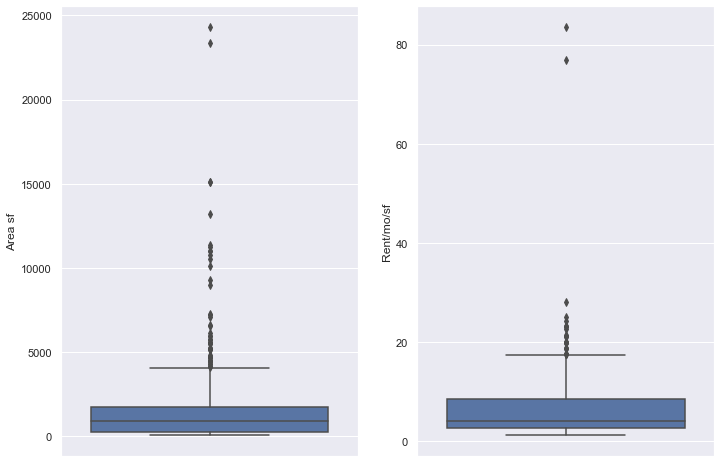

In [315]:
fig, ax = plt.subplots(1,2)

sns.boxplot(data=retail_gdf, y='Area sf', ax=ax[0]);
sns.boxplot(data=retail_gdf, y='Rent/mo/sf', ax=ax[1]);

We can see that there are multiple outliers for each metric. We will have to look at all these outliers to see if they are a consequence of an error in the data collection or if they indeed are valid data and we should keep them. For the area, we'll look at the outliers with the lowest values (closest to the 10th percentile value seen before) of rent per square foot since they are the most likely to have incorrect data. We will investigate these manually to confirm if they need to be removed or not.

In [319]:
from scipy import stats

q1 = retail_gdf['Area sf'].quantile(0.25)
q3 = retail_gdf['Area sf'].quantile(0.75)
iqr = q3 - q1

retail_gdf[(retail_gdf['Area sf'] > q3 + 1.5*iqr) & (retail_gdf['Rent/mo/sf'] < 2)]

,Address,Area sf,Rent/mo,Type,geometry,Main Address,latitude,longitude,Rent/mo/sf
Id,,,,,,,,,
318246,212 King St W,4500.00,7100.0,Office,POINT (-79.38633 43.64750),212 King St W,43.647500,-79.386329,1.577778
302519,119 - 100 Sunrise Ave,5131.00,7696.0,Industrial,POINT (-79.30895 43.71861),100 Sunrise Ave,43.718610,-79.308950,1.499903
336541,2 & 3 - 445 Milner Avenue,6577.00,9042.0,Industrial,POINT (-79.22882 43.79041),445 Milner Avenue,43.790413,-79.228822,1.374791
181106,201 - 55 Horner Avenue,10070.00,15902.0,Office,POINT (-79.51715 43.61431),55 Horner Avenue,43.614305,-79.517148,1.579146
335304,1 & 6 - 73 Samor Rd,11232.00,13572.0,Industrial,POINT (-79.46179 43.71704),73 Samor Rd,43.717041,-79.461795,1.208333
340633,17 Dora Ave,11000.00,20166.0,Industrial,POINT (-79.44376 43.65533),17 Dora Ave,43.655335,-79.443763,1.833273
l_95375186,365 King St W Flr 46,5488.56,9500.0,Commercial,POINT (-79.39260 43.64568),NaN,43.645675,-79.392605,1.730873


Checking the listings on the websites, the values check out. This indicates that the real state market is variable and depends on a lot of factors such as location, lease duration, owner, etc. Now let's see the outliers based on the rent prices.

In [322]:
q1 = retail_gdf['Rent/mo/sf'].quantile(0.25)
q3 = retail_gdf['Rent/mo/sf'].quantile(0.75)
iqr = q3 - q1

data = retail_gdf[(retail_gdf['Rent/mo/sf'] > q3 + 1.5*iqr)].sort_values(by='Rent/mo/sf', ascending=False)
data

,Address,Area sf,Rent/mo,Type,geometry,Main Address,latitude,longitude,Rent/mo/sf
Id,,,,,,,,,
288553,WeWork Office - 176 Yonge St,25.0,2090.0,Office,POINT (-79.37959 43.65211),176 Yonge St,43.652113,-79.379587,83.600000
288542,WeWork Office - 1050 King St W,25.0,1920.0,Office,POINT (-79.42159 43.64029),1050 King St W,43.640287,-79.421592,76.800000
337693,207 - 410 Adelaide St W,125.0,3500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,28.000000
313302,203 - 410 Adelaide St W,180.0,4500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,25.000000
294114,Office D - 1073 Yonge St,70.0,1700.0,Office,POINT (-79.39014 43.67893),1073 Yonge St,43.678929,-79.390136,24.285714
337686,205 - 410 Adelaide St W,150.0,3500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,23.333333
337678,201 - 410 Adelaide St W,280.0,6500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,23.214286
184289,403 - 32 Britain St,260.0,6000.0,Office,POINT (-79.37050 43.65389),32 Britain St,43.653893,-79.370504,23.076923
337692,206 - 410 Adelaide St W,155.0,3500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,22.580645


We see that all the outliers have the type 'Office'. The [average rent per square foot] of office spaces in Downtown Toronto is \\$38.79 per square foot. The first two entries in the table above have a rent per square foot value much larger than the average. Let's see where all these outliers are on a map using the __folium__ library. If they all are in Downtown Toronto, we'll investigate the first two. Otherwise, we'll also investigate those outside of the downtown area.

In [357]:
import folium

m = folium.Map(
    location=[43.65, -79.38],
    zoom_start=13,
    tiles='cartodbpositron',
    scrollWheelZoom=False
)

for lat, lng, rent in zip(data['latitude'], data['longitude'], data['Rent/mo/sf']):

    if 43.634256 < lat < 43.665202 and -79.347295 > lng > -79.411251:
        color = 'darkblue'
    else:
        color = 'red'
    
    folium.Circle(
        [lat, lng],
        popup=[lat, lng],
        radius=7,
        color=color,
        weight=7
    ).add_to(m)

m

On the map above, the blue points are inside the downtown area will the red ones aren't. We'll have to look at each group and determine whether there are invalid points. First let's look at the ones in the downtown area.

In [359]:
data.loc[
    (data['latitude'].between(43.634256, 43.665202)) & 
    (data['longitude'].between(-79.411251, -79.347295))].sort_values(by='Rent/mo/sf', ascending=False)

,Address,Area sf,Rent/mo,Type,geometry,Main Address,latitude,longitude,Rent/mo/sf
Id,,,,,,,,,
288553,WeWork Office - 176 Yonge St,25.0,2090.0,Office,POINT (-79.37959 43.65211),176 Yonge St,43.652113,-79.379587,83.600000
337693,207 - 410 Adelaide St W,125.0,3500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,28.000000
313302,203 - 410 Adelaide St W,180.0,4500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,25.000000
337686,205 - 410 Adelaide St W,150.0,3500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,23.333333
337678,201 - 410 Adelaide St W,280.0,6500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,23.214286
184289,403 - 32 Britain St,260.0,6000.0,Office,POINT (-79.37050 43.65389),32 Britain St,43.653893,-79.370504,23.076923
337692,206 - 410 Adelaide St W,155.0,3500.0,Office,POINT (-79.39658 43.64667),410 Adelaide St W,43.646673,-79.396577,22.580645
331721,102 - 375 University Ave,84.0,1799.0,Office,POINT (-79.38703 43.65357),375 University Ave,43.653569,-79.387029,21.416667
278433,404 - 32 Britain St,165.0,3500.0,Office,POINT (-79.37050 43.65389),32 Britain St,43.653893,-79.370504,21.212121


We see that every entry except for the first one is below the average rent per square foot in Downtown Toronto, so we won't remove those. The listing for the first entry explicitly states "Please contact for pricing and availability", which means that the price on the site is not reliable. Furthermore, there is another listing for the same location renting desks for \\$550/month which makes more sense since no one would \\$2090/month for 25 square feet! We will remove this entry.

In [360]:
retail_gdf = retail_gdf.loc[retail_gdf.index != '288553']

For the listings outside the downtown area, the only one above the average for downtown (highest price in the city) is the one below.

In [361]:
retail_gdf.loc[retail_gdf.index == '288542']

,Address,Area sf,Rent/mo,Type,geometry,Main Address,latitude,longitude,Rent/mo/sf
Id,,,,,,,,,
288542,WeWork Office - 1050 King St W,25.0,1920.0,Office,POINT (-79.42159 43.64029),1050 King St W,43.640287,-79.421592,76.8


Similar to the other listing (listed by WeWork, the same company as the one above), the price is not reliable so we will remove this one too.

In [362]:
retail_gdf = retail_gdf.loc[retail_gdf.index != '288542']

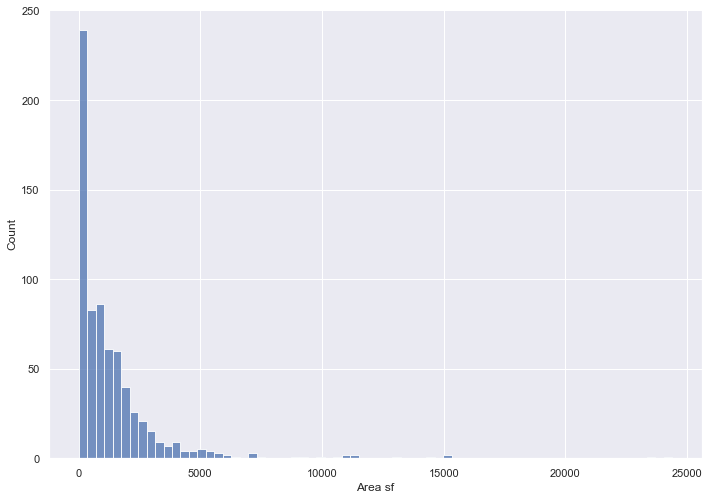

In [201]:
retail_gdf.hist(grid=False)

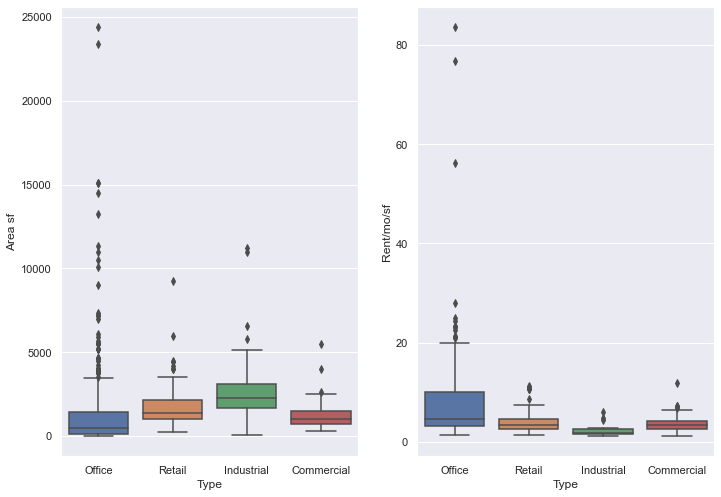

In [197]:
fig, ax = plt.subplots(1,2)

sns.boxplot(data=retail_gdf, x='Type', y='Area sf', ax=ax[0]);
sns.boxplot(data=retail_gdf, x='Type', y='Rent/mo/sf', ax=ax[1]);

Below is a distribution of the rent per month per squarefoot by type of space. Please note that the scale is log10.

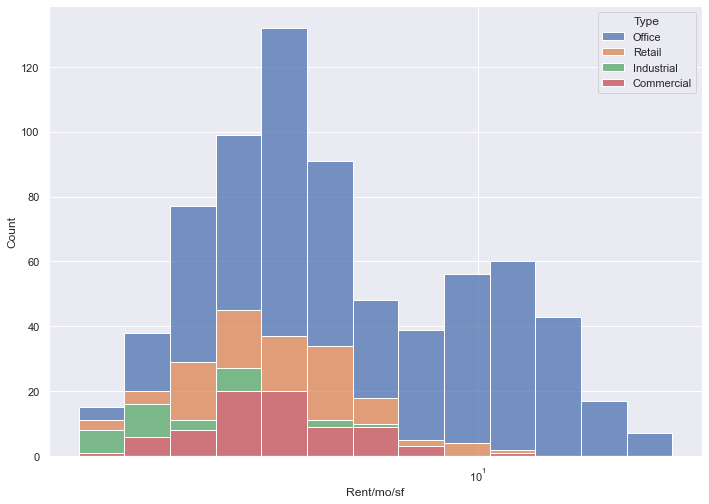

In [363]:
sns.histplot(retail_gdf, x='Rent/mo/sf', hue='Type', multiple='stack', log_scale=True);

We can see that the distributions for each type of space are centred near the same area. This indicates that the rent prices are consistent across the different types of spaces. That is, regardless of what type of space you are going to rent, the rent per squarefoot is similar to other types of spaces.
<br><br>
One interesting thing that we see from this plot is that for the 'Office' type, the distribution looks bimodal. In this context, it means that there are certain office spaces that charge more for rent compared to other types. Let's look at a scatterplot of the geographical coordinates of the spaces. The goal is to try to find where these more expensive office spaces are located. Below is the scatterplot coloured by the type of space. You can use your mouse to move the plot around and zoom in/out of areas.

In [364]:
fig = px.scatter(retail_gdf, x='longitude', y='latitude', color='Type', hover_data=['Rent/mo/sf'])

fig.update_layout(
    autosize=False,
    width=900,
    height=500,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

The downtown area is located around latitude and longitude values of (43.65, -79.38). Looking at the plot, we see that most of the spaces in the centre of downtown are office spaces. We can also see that commercial spaces are concentrated to the west of downtown, while retail spaces are scattered around the city. Industrial spaces are located on the outskirts of the city.
<br><br>
What are the areas where these spaces cost more to rent? To explore this, we'll look at KDE plots for each type of space.

In [378]:
types_to_show = ['Office']

fig = px.scatter(
    retail_gdf.loc[retail_gdf['Type'].isin(types_to_show)],
    x='longitude',
    y='latitude',
    color='Rent/mo/sf',
    hover_data=['Rent/mo/sf'])

fig.update_layout(
    autosize=False,
    width=900,
    height=500,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

From the plot it's hard to tell where the more expensive rents are since the values are close together. Let's try that again but now using a log scale to see more contrast in the rent differences.

In [534]:
retail_gdf.loc[:, 'Rent/mo/sf_log10'] = np.log10(retail_gdf.loc[:, 'Rent/mo/sf'])

fig = px.scatter(
    retail_gdf.loc[retail_gdf['Type'].isin(types_to_show)],
    x='longitude',
    y='latitude',
    color='Rent/mo/sf',
    hover_data=['Rent/mo/sf'])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

It's still hard to tell where the higher rent prices are, so let's try looking at KDE plots for the rent prices versus the latitude/longitude values.

In [657]:
from folium import plugins

# credit: https://alysivji.github.io/getting-started-with-folium.html
def map_points(df, middle_lat=43.705, middle_lon=-79.401323, lat_col='latitude', lon_col='longitude', zoom_start=12, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        middle_lat: latitude to center map at
        middle_lon: longitude to center map at
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start, scrollWheelZoom=False)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].values
        curr_map.add_child(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [658]:
def create_heatmap_df(df, min_range, max_range):
    heatmap_dict = {'latitude': [], 'longitude': []}

    min_rent = np.min(df['Rent/mo/sf'])
    max_rent = np.max(df['Rent/mo/sf'])

    min_range = -1
    max_range = 15
    df.loc[:, 'Rent/mo/sf_mapped'] = \
        np.round((df.loc[:, 'Rent/mo/sf'] - min_rent) * (max_range-min_range)/(max_rent-min_rent) + min_range)

    for lat, lon, rent_map in zip(df['latitude'], df['longitude'], df['Rent/mo/sf_mapped']):
        heatmap_dict['latitude'].extend([lat] * int(rent_map))
        heatmap_dict['longitude'].extend([lon] * int(rent_map))

    heatmap_df = pd.DataFrame.from_dict(heatmap_dict)
    
    return heatmap_df

In [659]:
s_type = 'Office'

data = retail_gdf.loc[retail_gdf['Type'] == s_type]

heatmap_df = create_heatmap_df(data, min_range=-1, max_range=15)

map_points(df=heatmap_df, draw_heatmap=True)

In [669]:
s_type = 'Retail'

data = retail_gdf.loc[retail_gdf['Type'] == s_type]

heatmap_df = create_heatmap_df(data, min_range=-1, max_range=15)

map_points(df=heatmap_df, draw_heatmap=True)

In [668]:
s_type = 'Commercial'

data = retail_gdf.loc[retail_gdf['Type'] == s_type]

heatmap_df = create_heatmap_df(data, min_range=-1, max_range=15)

map_points(df=heatmap_df, draw_heatmap=True)

In [666]:
s_type = 'Industrial'

data = retail_gdf.loc[retail_gdf['Type'] == s_type]

heatmap_df = create_heatmap_df(data, min_range=1, max_range=20)

map_points(df=heatmap_df, draw_heatmap=True)

In [525]:
from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

In [535]:
haver_dist = []

for i in range(retail_gdf.shape[0]):
    haver_dist.append(single_pt_haversine(retail_gdf.latitude[i], retail_gdf.longitude[i]))

retail_gdf.loc[:, 'HaversineDist'] = haver_dist
retail_gdf.loc[:, 'LatTimesLng'] = -1 * retail_gdf.loc[:, 'latitude'] * retail_gdf.loc[:, 'longitude']
retail_gdf.loc[:, 'LatLng'] = list(
    np.round(retail_gdf.loc[:, 'latitude'], 3).astype(str) + 
    ', ' +
    np.round(retail_gdf.loc[:, 'longitude'], 3).astype(str))

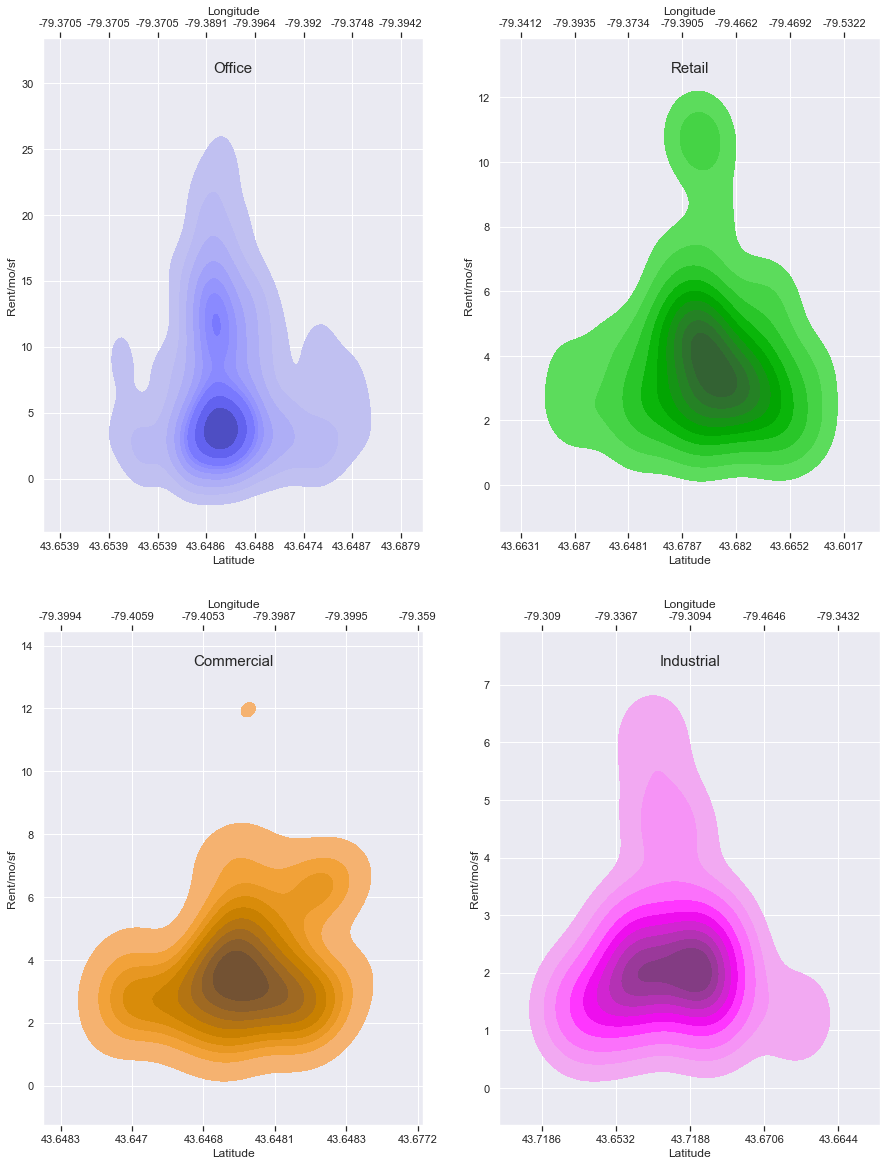

In [546]:
fig, ax = plt.subplots(2,2,figsize=(15,20))

for ij, s_type, color in zip(
    [[0,0], [0,1], [1,0], [1,1]], ['Office', 'Retail', 'Commercial', 'Industrial'], ['blue', 'green', 'orange', 'purple']
):
    data = retail_gdf.loc[retail_gdf['Type'] == s_type]
    
    sub_ax = sns.kdeplot(
        data=data, 
        x='HaversineDist',
        y='Rent/mo/sf',
        color=color,
        fill=True, 
        ax=ax[ij[0], ij[1]]);
    sub_ax.text(.5, .93, s_type, horizontalalignment='center', transform=sub_ax.transAxes, size=15)
    
    sub_ax.set_xticklabels(np.round(data['latitude'], 4), rotation=0)
    sub_ax.set_xlabel('Latitude')
    
    sub_ax2 = sub_ax.twiny()
    sub_ax2.set_xlim(sub_ax.get_xlim())
    sub_ax2.set_xticklabels(np.round(sub_ax.get_xticks(),1))
    sub_ax2.set_xticklabels(np.round(data['longitude'], 4), rotation=0)
    sub_ax2.set_xlabel('Longitude')
    sub_ax2.grid(b=False)
    
    plt.subplots_adjust(hspace=0.2)